
## Libraries


In [1]:
import random

# data manipulation libraries
import numpy as np
import pandas as pd

# machine learning libraries
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import heatmap

# deployment libraries
import onnxruntime as rt
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU



## Parameters 


In [3]:
batch_size    = 2048
learning_rate = 0.001
N_Epochs      = 100
epsilon       = 0.0001


## Read data


In [4]:
data_path = '../data/Chicago_Crimes_2018_to_2024.csv'
RAW_DATA = pd.read_csv(data_path, low_memory=False)

print("Shape of RAW_DATA:", RAW_DATA.shape)
RAW_DATA.head()

Shape of RAW_DATA: (1715081, 22)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,14004597,JJ459669,01/01/2025 12:00:00 AM,036XX S EMERALD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,11.0,60.0,14,1171897.0,1880767.0,2025,11/02/2025 03:41:09 PM,41.828279,-87.644829,"(41.828278889, -87.644829257)"
1,14011867,JJ468702,01/01/2025 12:00:00 AM,122XX S THROOP ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,...,21.0,53.0,14,1169881.0,1823639.0,2025,11/02/2025 03:41:09 PM,41.671556,-87.653881,"(41.671556077, -87.653880899)"
2,13989718,JJ442151,01/01/2025 12:00:00 AM,002XX S SANGAMON ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,APARTMENT,False,False,...,34.0,28.0,26,1170133.0,1899122.0,2025,11/02/2025 03:41:09 PM,41.878685,-87.650766,"(41.878685155, -87.650765871)"
3,13995949,JJ448524,01/01/2025 12:00:00 AM,044XX S MAPLEWOOD AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,...,12.0,58.0,08B,1160102.0,1875237.0,2025,11/02/2025 03:41:09 PM,41.813355,-87.688256,"(41.813355151, -87.688256413)"
4,13956936,JJ402427,01/01/2025 12:00:00 AM,072XX S RHODES AVE,1753,OFFENSE INVOLVING CHILDREN,SEXUAL ASSAULT OF CHILD BY FAMILY MEMBER,RESIDENCE,False,True,...,6.0,69.0,02,1181160.0,1857118.0,2025,11/02/2025 03:41:09 PM,41.763175,-87.611573,"(41.763175215, -87.611572995)"


In [5]:
RAW_DATA['Date'] = pd.to_datetime(RAW_DATA['Date'])
RAW_DATA['Date_Only'] = RAW_DATA['Date'].dt.normalize()

C:\Users\ikath\AppData\Local\Temp\ipykernel_9008\1816397136.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  RAW_DATA['Date'] = pd.to_datetime(RAW_DATA['Date'])


In [6]:
RAW_DATA['Day'] = RAW_DATA['Date'].dt.day_name()
RAW_DATA['Month'] = RAW_DATA['Date'].dt.month
RAW_DATA['Year'] = RAW_DATA['Date'].dt.year

In [7]:
FINAL_DATA = RAW_DATA.groupby([
	'Day', 'Month', 'Year', 'Ward',
	'Latitude', 'Longitude'
]).size().reset_index(name='Crime_Count')

# Convert Latitude and Longitude to float32
FINAL_DATA['Latitude'] = FINAL_DATA['Latitude'].astype('float32')
FINAL_DATA['Longitude'] = FINAL_DATA['Longitude'].astype('float32')

# Convert Day to categorical codes
FINAL_DATA['Day'] = FINAL_DATA['Day'].astype('category').cat.codes

# Convert 'Ward' to one-hot encoding
FINAL_DATA = pd.get_dummies(FINAL_DATA, columns=['Ward'], prefix='Ward')

In [8]:
print("Shape of FINAL_DATA:", FINAL_DATA.shape)
FINAL_DATA.head()

Shape of FINAL_DATA: (1569100, 56)


,Day,Month,Year,Latitude,Longitude,Crime_Count,Ward_1.0,Ward_2.0,Ward_3.0,Ward_4.0,...,Ward_41.0,Ward_42.0,Ward_43.0,Ward_44.0,Ward_45.0,Ward_46.0,Ward_47.0,Ward_48.0,Ward_49.0,Ward_50.0
0,0,1,2018,41.893787,-87.676994,1,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,1,2018,41.893955,-87.685303,1,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,1,2018,41.894043,-87.680092,1,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,1,2018,41.895065,-87.672798,1,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,1,2018,41.895145,-87.668045,1,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
headers_list = FINAL_DATA.columns.values.tolist()
headers_list

['Day',
 'Month',
 'Year',
 'Latitude',
 'Longitude',
 'Crime_Count',
 'Ward_1.0',
 'Ward_2.0',
 'Ward_3.0',
 'Ward_4.0',
 'Ward_5.0',
 'Ward_6.0',
 'Ward_7.0',
 'Ward_8.0',
 'Ward_9.0',
 'Ward_10.0',
 'Ward_11.0',
 'Ward_12.0',
 'Ward_13.0',
 'Ward_14.0',
 'Ward_15.0',
 'Ward_16.0',
 'Ward_17.0',
 'Ward_18.0',
 'Ward_19.0',
 'Ward_20.0',
 'Ward_21.0',
 'Ward_22.0',
 'Ward_23.0',
 'Ward_24.0',
 'Ward_25.0',
 'Ward_26.0',
 'Ward_27.0',
 'Ward_28.0',
 'Ward_29.0',
 'Ward_30.0',
 'Ward_31.0',
 'Ward_32.0',
 'Ward_33.0',
 'Ward_34.0',
 'Ward_35.0',
 'Ward_36.0',
 'Ward_37.0',
 'Ward_38.0',
 'Ward_39.0',
 'Ward_40.0',
 'Ward_41.0',
 'Ward_42.0',
 'Ward_43.0',
 'Ward_44.0',
 'Ward_45.0',
 'Ward_46.0',
 'Ward_47.0',
 'Ward_48.0',
 'Ward_49.0',
 'Ward_50.0']

## Correlation matrix

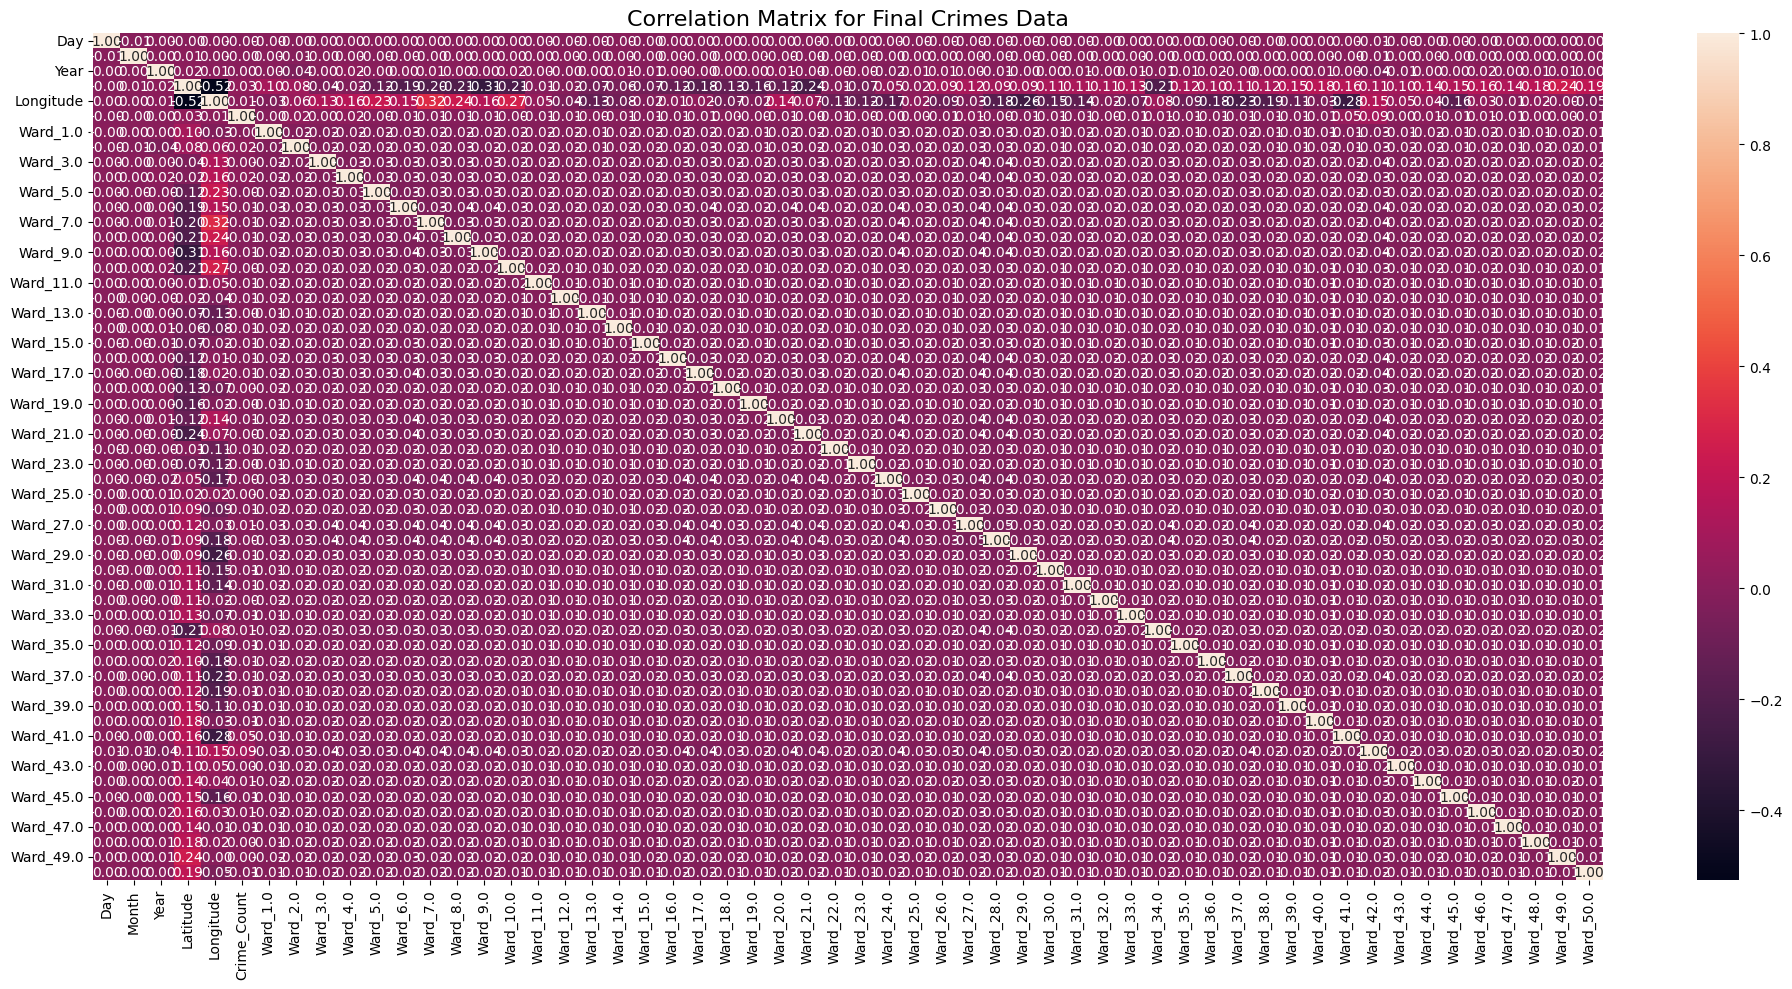

In [10]:
plt.figure(figsize=(20, 10))
sns.heatmap(FINAL_DATA.corr(), annot=True, fmt=".2f")
plt.title("Correlation Matrix for Final Crimes Data", fontsize=16)
plt.tight_layout()
plt.show()


## Process Data


In [11]:
y = FINAL_DATA['Crime_Count'].to_numpy()
X = FINAL_DATA.drop(columns=['Crime_Count']).to_numpy()

In [12]:
print(X.shape)
print(y.shape)

(1569100, 55)
(1569100,)


In [13]:
random_seed = int( random.random() * 100 )
random_seed

38

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [15]:
input_dim = X_train.shape[1]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1255280, 55)
(313820, 55)
(1255280,)
(313820,)


In [16]:
y_test.dtype

dtype('int64')


## Fix in case float64 error


In [17]:
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test  = y_test.astype(np.float32)

In [18]:
X_train_tr = torch.from_numpy(X_train).to(device)
X_test_tr  = torch.from_numpy(X_test).to(device)
y_train_tr = torch.from_numpy(y_train).to(device)
y_test_tr = torch.from_numpy(y_test).to(device)


## Normalization

* Normalizartion
* Standardization (*)


In [19]:
x_means = X_train_tr.mean(0, keepdim=True)
x_deviations = X_train_tr.std(0, keepdim=True) + epsilon

In [20]:
x_means

tensor([[ 2.9711e+00,  6.6182e+00,  2.0210e+03,  4.1844e+01, -8.7670e+01,
          1.7869e-02,  1.8767e-02,  2.8128e-02,  2.6759e-02,  2.4325e-02,
          3.7814e-02,  3.0335e-02,  3.1689e-02,  3.0602e-02,  1.7504e-02,
          1.2706e-02,  1.2329e-02,  1.0036e-02,  1.2891e-02,  1.6620e-02,
          2.9487e-02,  3.2566e-02,  1.4808e-02,  9.0585e-03,  3.1758e-02,
          3.1187e-02,  1.2997e-02,  1.0793e-02,  3.8979e-02,  1.7940e-02,
          1.6288e-02,  4.4515e-02,  4.6131e-02,  2.3238e-02,  1.1427e-02,
          1.2446e-02,  1.3329e-02,  1.0450e-02,  2.6243e-02,  1.2194e-02,
          1.2851e-02,  2.7995e-02,  9.1924e-03,  1.0037e-02,  1.2170e-02,
          9.8703e-03,  4.1441e-02,  1.1836e-02,  1.5138e-02,  1.1044e-02,
          1.4367e-02,  1.0545e-02,  1.1912e-02,  1.5867e-02,  1.1528e-02]],
       device='cuda:0')

In [21]:
x_deviations

tensor([[2.0046, 3.3628, 2.0614, 0.0878, 0.0592, 0.1326, 0.1358, 0.1654, 0.1615,
         0.1542, 0.1908, 0.1716, 0.1753, 0.1723, 0.1312, 0.1121, 0.1104, 0.0998,
         0.1129, 0.1279, 0.1693, 0.1776, 0.1209, 0.0948, 0.1755, 0.1739, 0.1134,
         0.1034, 0.1936, 0.1328, 0.1267, 0.2063, 0.2099, 0.1508, 0.1064, 0.1110,
         0.1148, 0.1018, 0.1600, 0.1099, 0.1127, 0.1651, 0.0955, 0.0998, 0.1097,
         0.0990, 0.1994, 0.1082, 0.1222, 0.1046, 0.1191, 0.1022, 0.1086, 0.1251,
         0.1068]], device='cuda:0')


## Create the DataLoader


In [22]:
train_ds = TensorDataset(X_train_tr, y_train_tr)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=6,
    persistent_workers=True,
)


## Neural Network Architectures


In [23]:
class LinRegNet(nn.Module):
    """Linear Regression"""

    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(input_dim, 1)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        y_pred = self.linear1(x)
        ## return torch.round( y_pred )
        return y_pred

In [24]:
class MLP_Net(nn.Module):
    """MLP"""
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(input_dim, 8)
        self.act1    = nn.Sigmoid()
        self.linear2 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        y_pred = self.linear2(x)
        
        ## return torch.round( y_pred )
        return y_pred

In [25]:
class DL_Net(nn.Module):
    """Deep Learning with 2 hidden layers"""
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(input_dim, 9)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(9, 6)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        ## x = self.dropout(x)
        y_pred = self.linear3(x)
        
        ## return torch.round( y_pred )
        return y_pred

In [26]:
class LinearPlusNonLinear_Net(nn.Module):
    """Linear plus Nonlinear"""
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(input_dim, 1)
        
        ## F2
        self.f2_linear1 = nn.Linear(input_dim, 14)
        self.f2_act1    = nn.Sigmoid()
        self.f2_linear2 = nn.Linear(14, 1)
        
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_linear2(f2)
        
        y_pred = f1 + f2
        
        ## return torch.round( y_pred )
        return y_pred

## Training Loop

In [27]:
def training_loop(N_Epochs, model, loss_fn, opt):
    
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)

            yb = yb.unsqueeze(1)
            
            y_pred = model(xb)

            loss   = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
        if epoch % 20 == 0:
            print(epoch, "loss=", loss)

In [28]:
linreg_model = LinRegNet(x_means, x_deviations).to(device)

opt = torch.optim.Adam(linreg_model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop(N_Epochs, linreg_model, loss_fn, opt)

0 loss= tensor(0.3907, device='cuda:0', grad_fn=<MseLossBackward0>)
20 loss= tensor(0.2162, device='cuda:0', grad_fn=<MseLossBackward0>)
40 loss= tensor(0.1296, device='cuda:0', grad_fn=<MseLossBackward0>)
60 loss= tensor(0.1117, device='cuda:0', grad_fn=<MseLossBackward0>)
80 loss= tensor(0.0906, device='cuda:0', grad_fn=<MseLossBackward0>)


In [31]:
y_pred_test_linreg = linreg_model(X_test_tr)
print( "LinReg R**2 : ", r2_score(y_test_tr.cpu().numpy(),  y_pred_test_linreg.cpu().detach().numpy()))

LinReg R**2 :  0.014157772064208984


In [29]:
mlp_model = MLP_Net(x_means, x_deviations).to(device)

opt = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop(N_Epochs, mlp_model, loss_fn, opt)

0 loss= tensor(0.1394, device='cuda:0', grad_fn=<MseLossBackward0>)
20 loss= tensor(0.1223, device='cuda:0', grad_fn=<MseLossBackward0>)
40 loss= tensor(0.1362, device='cuda:0', grad_fn=<MseLossBackward0>)
60 loss= tensor(0.1075, device='cuda:0', grad_fn=<MseLossBackward0>)
80 loss= tensor(0.1103, device='cuda:0', grad_fn=<MseLossBackward0>)


In [32]:
y_pred_test_mlp    = mlp_model(X_test_tr)
print( "MLP R**2    : ", r2_score(y_test_tr.cpu().numpy(),  y_pred_test_mlp.cpu().detach().numpy()))

MLP R**2    :  0.01765519380569458


In [34]:
dl_model = DL_Net(x_means, x_deviations).to(device)

opt = torch.optim.Adam(dl_model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop(N_Epochs, dl_model, loss_fn, opt)

0 loss= tensor(0.1199, device='cuda:0', grad_fn=<MseLossBackward0>)
20 loss= tensor(0.1042, device='cuda:0', grad_fn=<MseLossBackward0>)
40 loss= tensor(0.0898, device='cuda:0', grad_fn=<MseLossBackward0>)
60 loss= tensor(0.0942, device='cuda:0', grad_fn=<MseLossBackward0>)
80 loss= tensor(0.1395, device='cuda:0', grad_fn=<MseLossBackward0>)


In [35]:
y_pred_test_dl = dl_model(X_test_tr)
print( "DL R**2     : ", r2_score(y_test_tr.cpu().numpy(),  y_pred_test_dl.cpu().detach().numpy()))

DL R**2     :  0.03591388463973999


In [36]:
mix_model = LinearPlusNonLinear_Net(x_means, x_deviations).to(device)

opt = torch.optim.Adam(mix_model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop(N_Epochs, mix_model, loss_fn, opt)

0 loss= tensor(0.1480, device='cuda:0', grad_fn=<MseLossBackward0>)
20 loss= tensor(0.1141, device='cuda:0', grad_fn=<MseLossBackward0>)
40 loss= tensor(0.1070, device='cuda:0', grad_fn=<MseLossBackward0>)
60 loss= tensor(0.0930, device='cuda:0', grad_fn=<MseLossBackward0>)
80 loss= tensor(0.1013, device='cuda:0', grad_fn=<MseLossBackward0>)


In [37]:
y_pred_test_mix    = mix_model(X_test_tr)
print("Mix R**2    : ", r2_score(y_test_tr.cpu().numpy(),  y_pred_test_mix.cpu().detach().numpy()))

Mix R**2    :  0.031060874462127686



## Deploy PyTorch Model


In [39]:
models = {
    "linreg_model": linreg_model,
    "mlp_model": mlp_model,
    "dl_model": dl_model,
    "mix_model": mix_model
}

for model_name, model in models.items():
    model.eval()

    dummy_input = torch.randn(1, input_dim).to(device)

    input_names = ["input1"]
    output_names = ["output1"]

    torch.onnx.export(
        model,
        dummy_input,
        f"{model_name}_Regression.onnx",
        verbose=False,
        input_names=input_names,
        output_names=output_names
    )

C:\Users\ikath\AppData\Local\Temp\ipykernel_9008\1981014239.py:16: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
